In [122]:
from physDBD import ImportHelper, DataDesc, Params0GaussTraj, RxnInputsGaussLayer, \
    DParams0GaussTraj, RxnGaussModel, TrainingGaussData, DataTypeGauss, DParams0Gauss, Params0Gauss
import numpy as np
import tensorflow as tf
import sys
import os
import datetime
import pickle
import matplotlib.pyplot as plt
import copy

# Analyze trained

In [123]:
model_trained = tf.keras.models.load_model("trained/trained_final")

# Load lowest validation weights
model_trained.load_weights("trained/weights_lowest_val")

In [124]:
mean_mu = np.loadtxt("cache/trans_params_mean_mu.txt")
mean_chol_v_vec = np.loadtxt("cache/trans_params_mean_chol_v_vec.txt")
stddev_mu = np.loadtxt("cache/trans_params_stddev_mu.txt")
stddev_chol_v_vec = np.loadtxt("cache/trans_params_stddev_chol_v_vec.txt")

mean_dmu = np.loadtxt("cache/trans_params_norm_deriv_mean_dmu.txt")
mean_dchol_v_vec = np.loadtxt("cache/trans_params_norm_deriv_mean_dchol_v_vec.txt")
stddev_dmu = np.loadtxt("cache/trans_params_norm_deriv_stddev_dmu.txt")
stddev_dchol_v_vec = np.loadtxt("cache/trans_params_norm_deriv_stddev_dchol_v_vec.txt")

## Integrate

In [125]:
def un_normalize_deriv(dparam):
    # Un-normalize
    dparam_ret = copy.deepcopy(dparam)
    dparam_ret.dmu_v = stddev_dmu * dparam_ret.dmu_v + mean_dmu
    dparam_ret.dchol_v[0,0] = stddev_dchol_v_vec[0] * dparam_ret.dchol_v[0,0] + mean_dchol_v_vec[0]
    dparam_ret.dchol_v[1,0] = stddev_dchol_v_vec[1] * dparam_ret.dchol_v[1,0] + mean_dchol_v_vec[1]
    dparam_ret.dchol_v[1,1] = stddev_dchol_v_vec[2] * dparam_ret.dchol_v[1,1] + mean_dchol_v_vec[2]
    return dparam_ret

def un_normalize_param(param):
    # Un-normalize
    param_ret = copy.deepcopy(param)
    param_ret.mu_v = stddev_mu * param_ret.mu_v + mean_mu
    param_ret.chol_v[0,0] = stddev_chol_v_vec[0] * param_ret.chol_v[0,0] + mean_chol_v_vec[0]
    param_ret.chol_v[1,0] = stddev_chol_v_vec[1] * param_ret.chol_v[1,0] + mean_chol_v_vec[1]
    param_ret.chol_v[1,1] = stddev_chol_v_vec[2] * param_ret.chol_v[1,1] + mean_chol_v_vec[2]
    return param_ret

def normalize_param(param):
    # Un-normalize
    param_ret = copy.deepcopy(param)
    param_ret.mu_v = ( param_ret.mu_v - mean_mu ) / stddev_mu
    param_ret.chol_v[0,0] = ( param_ret.chol_v[0,0] - mean_chol_v_vec[0] ) / stddev_chol_v_vec[0]
    param_ret.chol_v[1,0] = ( param_ret.chol_v[1,0] - mean_chol_v_vec[1] ) / stddev_chol_v_vec[1]
    param_ret.chol_v[1,1] = ( param_ret.chol_v[1,1] - mean_chol_v_vec[2] ) / stddev_chol_v_vec[2]
    return param_ret

In [126]:
def model_outputs_to_dparams(vals: np.array) -> DParams0Gauss:
    return DParams0Gauss.fromLFdict({
        "dmu_v_0": vals[0],
        "dmu_v_1": vals[1],
        "dchol_v_0_0": vals[2],
        "dchol_v_1_0": vals[3],
        "dchol_v_1_1": vals[4]
        }, nv=2)

In [127]:
def predict_params0_norm_deriv(params0_norm_curr: Params0Gauss, verbose: bool = True) -> DParams0Gauss:
    if verbose:
        print("Params0 norm curr", params0_norm_curr)

    x = params0_norm_curr
    input0 = np.array([[x.mu_v[0], x.mu_v[1], x.chol_v[0,0], x.chol_v[1,0], x.chol_v[1,1]]])
    output0 = model_trained(input0)[0]

    params0_norm_deriv_norm = model_outputs_to_dparams(output0)
    if verbose:
        print("Params0 norm deriv norm",params0_norm_deriv_norm)

    params0_norm_deriv = un_normalize_deriv(params0_norm_deriv_norm)
    if verbose:
        print("Params0 norm deriv",params0_norm_deriv)
    
    return params0_norm_deriv

In [141]:
params0_norm_traj = Params0GaussTraj.fromFile("cache/cache_params_norm_filtered.txt", nv=2)
tpt_start = 000
params0_norm_start = params0_norm_traj.params0_traj[tpt_start]
print("Params0 norm start",params0_norm_start)

Params0 norm start Params0Gauss(mu_v=array([1.28236119, 3.19981535]), chol_v=array([[4.47907057, 0.        ],
       [0.61497851, 0.41298567]]), _nv=2)


In [145]:
params0_norm_int = [params0_norm_start]

no_tpts = 1000
for tpt in range(0,no_tpts):
    if tpt % int(no_tpts/10.0) == 0:
        print("%03d / %03d" % (tpt, no_tpts))

    params0_norm_deriv = predict_params0_norm_deriv(params0_norm_int[-1], verbose=False)

    params0_norm_next = Params0Gauss.addDeriv(params0_norm_int[-1], params0_norm_deriv)

    params0_next = un_normalize_param(params0_norm_next)

    # Ensure diag > 0
    for i in range(0,2):
        params0_next.chol_v[i,i] = max(params0_next.chol_v[i,i],0.0)

    # Normalize again
    params0_norm_next = normalize_param(params0_next)

    params0_norm_int.append(params0_norm_next)
    # print("Params0 norm next",params0_norm_next)

000 / 1000
100 / 1000
200 / 1000
300 / 1000
400 / 1000
500 / 1000
600 / 1000
700 / 1000
800 / 1000
900 / 1000


Text(0.5, 0, 'timepoint')

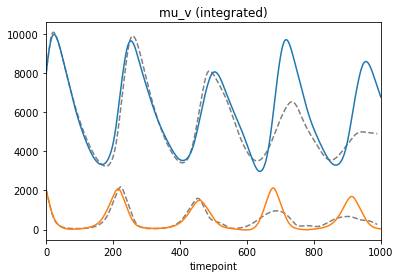

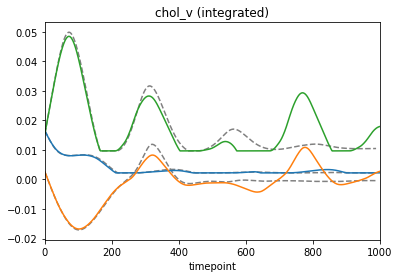

In [146]:
params0_int = [un_normalize_param(p) for p in params0_norm_int]

# Import params traj
params0_traj_filtered = Params0GaussTraj.fromFile("cache/cache_params_filtered.txt", nv=2)

tpts_int = np.arange(tpt_start,tpt_start+len(params0_int))

plt.figure()
plt.plot([x.mu_v[0] for x in params0_traj_filtered.params0_traj], color="gray", linestyle="dashed")
plt.plot([x.mu_v[1] for x in params0_traj_filtered.params0_traj], color="gray", linestyle="dashed")
plt.plot(tpts_int,[x.mu_v[0] for x in params0_int])
plt.plot(tpts_int,[x.mu_v[1] for x in params0_int])
plt.xlim(0,1000)
plt.title("mu_v (integrated)")
plt.xlabel("timepoint")

plt.figure()
plt.plot([x.chol_v[0,0] for x in params0_traj_filtered.params0_traj], color="gray", linestyle="dashed")
plt.plot([x.chol_v[1,0] for x in params0_traj_filtered.params0_traj], color="gray", linestyle="dashed")
plt.plot([x.chol_v[1,1] for x in params0_traj_filtered.params0_traj], color="gray", linestyle="dashed")
plt.plot(tpts_int,[x.chol_v[0,0] for x in params0_int])
plt.plot(tpts_int,[x.chol_v[1,0] for x in params0_int])
plt.plot(tpts_int,[x.chol_v[1,1] for x in params0_int])
plt.xlim(0,1000)
plt.title("chol_v (integrated)")
plt.xlabel("timepoint")

(0.0, 1000.0)

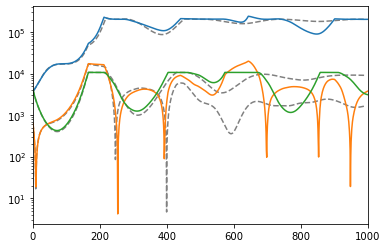

In [147]:
cov_v_int = [abs(x.cov_v) for x in params0_int]

# Import params traj
params0_traj_filtered = Params0GaussTraj.fromFile("cache/cache_params_filtered.txt", nv=2)
cov_v_filtered = [abs(x.cov_v) for x in params0_traj_filtered.params0_traj]

tpts_int = np.arange(tpt_start,tpt_start+len(params0_int))

plt.figure()
plt.plot([x[0,0] for x in cov_v_filtered], color='gray', linestyle="dashed")
plt.plot([x[1,0] for x in cov_v_filtered], color='gray', linestyle="dashed")
plt.plot([x[1,1] for x in cov_v_filtered], color='gray', linestyle="dashed")
plt.plot(tpts_int,[x[0,0] for x in cov_v_int])
plt.plot(tpts_int,[x[1,0] for x in cov_v_int])
plt.plot(tpts_int,[x[1,1] for x in cov_v_int])
plt.yscale("log")
plt.xlim(0,1000)